In [1]:
import os
from scipy import io
import glob
import time
import random
from pathlib import Path
import pandas as pd
import numpy as np
import numpy
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import RDKFingerprint, SDMolSupplier
from scipy.io import savemat

In [2]:
# create instance of sdf reader
suppl_pos = SDMolSupplier('C:/Users/hjooya/AI_in_Sciences_Project/MATLAB-Python/GitHub_Posts/Chemical_ML_DL/Tox21_Analysis_Go_To_GitHub/Tox21_Data/Tox21_Pos_Data.sdf')
suppl_neg = SDMolSupplier('C:/Users/hjooya/AI_in_Sciences_Project/MATLAB-Python/GitHub_Posts/Chemical_ML_DL/Tox21_Analysis_Go_To_GitHub/Tox21_Data/Tox21_Neg_Data.sdf')

# read all molecules besides ones with errors into a list
mols_pos = [molpos for molpos in suppl_pos if molpos is not None]
mols_neg = [molneg for molneg in suppl_neg if molneg is not None]

# calculate fingerprints
fps_pos = [RDKFingerprint(molpos) for molpos in mols_pos]
fps_neg = [RDKFingerprint(molneg) for molneg in mols_neg]

# How many compounds/fingerprints do we have?
print("number of negative compounds:", len(fps_neg))
print("fp length per negative compound:", len(fps_neg[0]))


# How many compounds/fingerprints do we have?
print("number of positive compounds:", len(fps_pos))
print("fp length per positive compound:", len(fps_pos[0]))


number of negative compounds: 5066
fp length per negative compound: 2048
number of positive compounds: 1658
fp length per positive compound: 2048


In [4]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [5]:
# Example: Calculate single similarity of two fingerprints of negative compounds
[i,j] =random.sample(range(1, len(fps_neg)), 2)
sim_neg = DataStructs.TanimotoSimilarity(fps_neg[i], fps_neg[j])
print(f"Tanimoto similarity for negative dataset: {sim_neg:.2f}")

# Example: Calculate single similarity of two fingerprints of positive compounds
[i,j] =random.sample(range(1, len(fps_pos)), 2)
sim_pos = DataStructs.TanimotoSimilarity(fps_pos[i], fps_pos[j])
print(f"Tanimoto similarity for positive dataset: {sim_pos:.2f}")

Tanimoto similarity for negative dataset: 0.38
Tanimoto similarity for positive dataset: 0.27


In [24]:
sizeneg=len(mols_neg)
similarneg=np.empty(shape=(sizeneg,sizeneg))
for index, i in enumerate(fps_neg):
    for jndex, j in enumerate(fps_neg):
        similarityneg=DataStructs.FingerprintSimilarity(i,j)
        similarneg[index,jndex]=similarityneg

with open('similarneg.npy', 'wb') as f:
     np.save(f, similarneg)

io.savemat('similarneg.mat', {"data": similarneg })
simhist = "similarneg.mat"

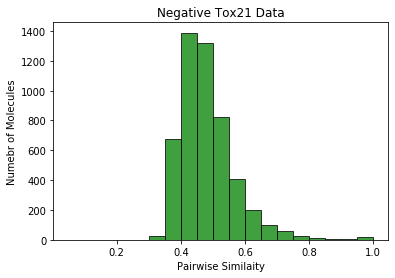

<Figure size 432x288 with 0 Axes>

In [25]:
plt.title('Negative Tox21 Data')
plt.xlabel('Pairwise Similaity')
plt.ylabel('Numebr of Molecules')
lenfpsneg = len(fps_neg)
countsneg = similarneg[np.triu_indices(lenfpsneg)]
weightsneg = np.ones_like(countsneg) / float(len(countsneg))
weightsneg = weightsneg*lenfpsneg
plt.hist(countsneg,bins=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0], weights=weightsneg,edgecolor = "black",alpha=0.75, color='green')
plt.show()
plt.savefig('negative_histogram.png')

In [28]:
sizepos=len(mols_pos)
similarpos=np.empty(shape=(sizepos,sizepos))
for index, i in enumerate(fps_pos):
    for jndex, j in enumerate(fps_pos):
        similaritypos=DataStructs.FingerprintSimilarity(i,j)
        similarpos[index,jndex]=similaritypos

with open('similarpos.npy', 'wb') as f:
     np.save(f, similarpos)

io.savemat('similarpos.mat', {"data": similarpos })
simhist = "similarpos.mat"

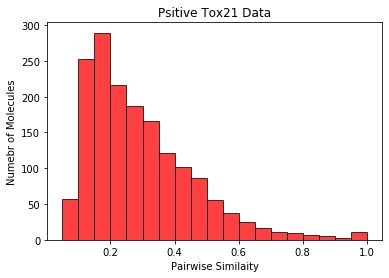

<Figure size 432x288 with 0 Axes>

In [29]:
plt.title('Psitive Tox21 Data')
plt.xlabel('Pairwise Similaity')
plt.ylabel('Numebr of Molecules')
lenfpspos = len(fps_pos)
countspos = similarpos[np.triu_indices(lenfpspos)]
weightspos = np.ones_like(countspos) / float(len(countspos))
weightspos = weightspos*lenfpspos
plt.hist(countspos,bins=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0], weights=weightspos,edgecolor = "black",alpha=0.75, color='red')
plt.show()
plt.savefig('posative_histogram.png')

In [6]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [13]:
# Run the clustering procedure for the dataset
clusters_pos = cluster_fingerprints(fps_pos, cutoff=0.6)

# Give a short report about the numbers of clusters and their sizes
num_clust_pos_g1 = sum(1 for c in clusters_pos if len(c) == 1)
num_clust_pos_g5 = sum(1 for c in clusters_pos if len(c) > 5)
num_clust_pos_g25 = sum(1 for c in clusters_pos if len(c) > 25)
num_clust_pos_g100 = sum(1 for c in clusters_pos if len(c) > 100)

print("total # positive clusters: ", len(clusters_pos))
print("# positive clusters with only 1 compound: ", num_clust_pos_g1)
print("# positive clusters with >5 compounds: ", num_clust_pos_g5)
print("# positive clusters with >25 compounds: ", num_clust_pos_g25)
print("# positive clusters with >100 compounds: ", num_clust_pos_g100)

total # positive clusters:  11
# positive clusters with only 1 compound:  1
# positive clusters with >5 compounds:  9
# positive clusters with >25 compounds:  8
# positive clusters with >100 compounds:  5


Visualize molecules from the largest cluster:


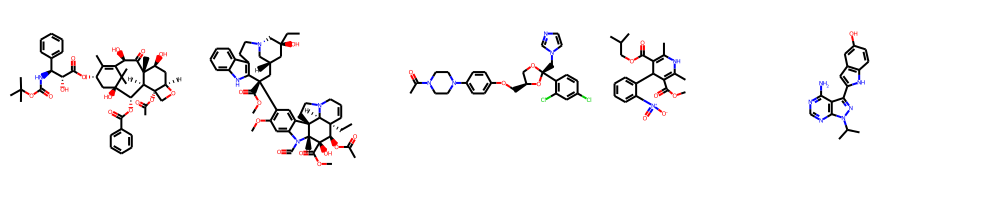

In [11]:
print("Visualize molecules from the largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [mols_pos[i] for i in clusters_pos[0][:5]],
    molsPerRow=5,
)

Visualize positive molecules from first 10 clusters:


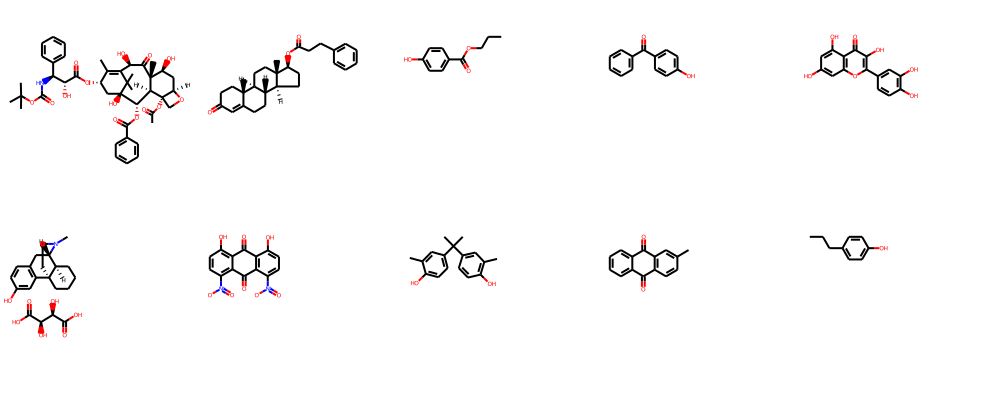

In [22]:
print("Visualize positive molecules from first 10 clusters:")
# Draw molecules
Draw.MolsToGridImage(
    [mols_pos[clusters_pos[i][0]] for i in range(10)],
    molsPerRow=5,
)

In [19]:
HERE = Path(_dh[-1])
DATA = HERE / "sdf_Data"

In [20]:
# Save molecules from largest positive cluster for futher analysis
sdf_path = str(DATA / "Pos_Molecules_from_largest_cluster.sdf")
sdf = Chem.SDWriter(sdf_path)
for index in clusters_pos[0]:
    mol = mols_pos[index]
    # Add label to metadata
    sdf.write(mol)
sdf.close()

In [24]:
# Run the clustering procedure for the dataset
clusters_neg = cluster_fingerprints(fps_neg, cutoff=0.8)

# Give a short report about the numbers of clusters and their sizes
num_clust_neg_g1 = sum(1 for c in clusters_neg if len(c) == 1)
num_clust_neg_g5 = sum(1 for c in clusters_neg if len(c) > 5)
num_clust_neg_g25 = sum(1 for c in clusters_neg if len(c) > 25)
num_clust_neg_g100 = sum(1 for c in clusters_neg if len(c) > 100)

print("total # negative clusters: ", len(clusters_neg))
print("# positive clusters with only 1 compound: ", num_clust_neg_g1)
print("# positive clusters with >5 compounds: ", num_clust_neg_g5)
print("# positive clusters with >25 compounds: ", num_clust_neg_g25)
print("# positive clusters with >100 compounds: ", num_clust_neg_g100)

total # negative clusters:  1
# positive clusters with only 1 compound:  0
# positive clusters with >5 compounds:  1
# positive clusters with >25 compounds:  1
# positive clusters with >100 compounds:  1


Visualize molecules from the largest cluster:


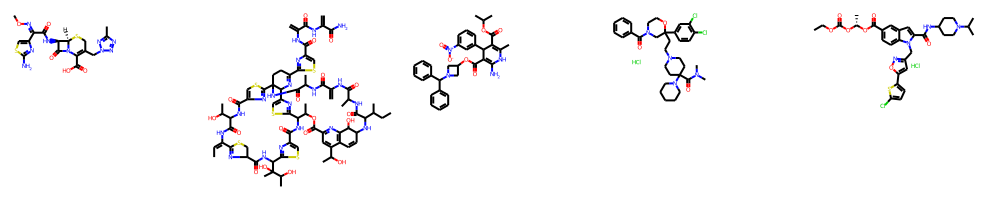

In [16]:
print("Visualize molecules from the largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [mols_neg[i] for i in clusters_neg[0][:5]],
    molsPerRow=5,
)

In [21]:
# Save molecules from largest negative cluster for futher analysis
sdf_path = str(DATA / "Neg_Molecules_from_largest_cluster.sdf")
sdf = Chem.SDWriter(sdf_path)
for index in clusters_neg[0]:
    mol = mols_neg[index]
    # Add label to metadata
    sdf.write(mol)
sdf.close()